# Classic Segmentation

In this notebook, we will segment the `cells` image using a traditional [ImageJ segmentation workflow](https://imagej.net/imaging/segmentation#flexible-workflow):

1. Preprocess the image
2. Apply an auto threshold
3. Create and manipulate a mask
4. Create and transfer a selection from the mask to the original image
5. Analyze the resulting data

<table><tr><td>

💡 See the ["Segmentation with ImageJ" living workshop](https://imagej.net/events/presentations#living-workshops) for a primer on segmentation in ImageJ.

</td></tr></table>

We will do the same analysis twice: once with ImageJ, and then again with ImageJ2.

## Segmentation workflow with original ImageJ functions

In [1]:
import imagej
import scyjava as sj

# initialize ImageJ
ij = imagej.init('sc.fiji:fiji', mode='interactive')
print(f"ImageJ version: {ij.getVersion()}")

ImageJ version: 2.14.0/1.54f


In [2]:
import skimage
cells = skimage.data.cells3d()

Because this sample image is a NumPy array, but not an xarray, it does not have dimensional axis labels. However, scikit-image has [defined conventions](https://scikit-image.org/docs/dev/user_guide/numpy_images.html#coordinate-conventions) for the order of dimensions as follows:

    (t, pln, row, col, ch)

Where `t` is time, `pln` is plane/Z, `row` is row/Y, `col` is column/X, and `ch` is channel.

Now that we are armed with that knowledge, notice that `cells` actually has a slightly different dimension order, with planar rather than interleaved channels: `(pln, ch, row, col)`. Let's construct an xarray from this image that includes the correct dimensional axis labels:

In [3]:
import xarray
xcells = xarray.DataArray(cells, name='xcells', dims=('pln', 'ch', 'row', 'col'))

# print some basic info
print(f"name: {xcells.name}\ndimensions: {xcells.dims}\nshape: {xcells.shape}")

name: xcells
dimensions: ('pln', 'ch', 'row', 'col')
shape: (60, 2, 256, 256)


In [4]:
# convert xcells image to ImagePlus
imp = ij.py.to_imageplus(xcells)
imp.setTitle("cells")

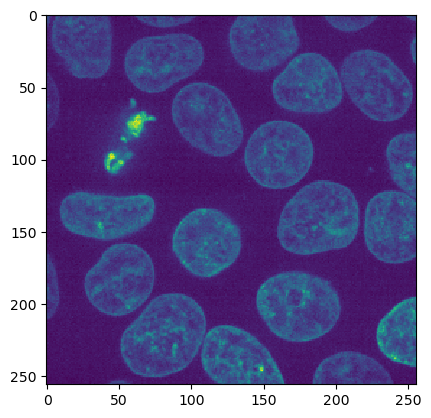

In [5]:
# slice out an image plane.
c, z, t = 2, 36, 1
Duplicator = sj.jimport('ij.plugin.Duplicator')
imp2d = Duplicator().run(imp, c, c, z, z, t, t)
imp2d.setTitle("cells-slice")
ij.py.show(imp2d)

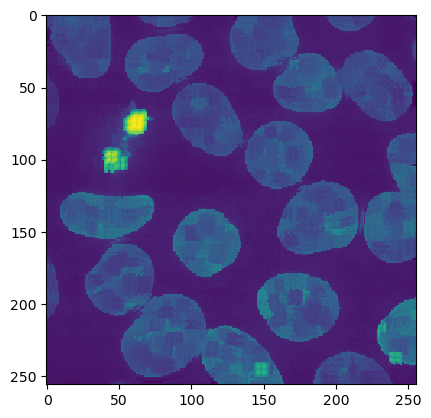

In [6]:
# preprocess with edge-preserving smoothing
ij.IJ.run(imp2d, "Kuwahara Filter", "sampling=10") # Look ma, a Fiji plugin!
ij.py.show(imp2d)

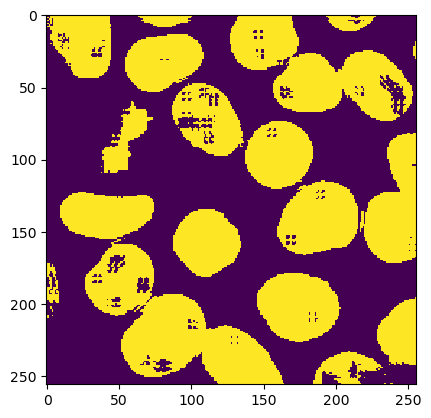

In [7]:
# threshold to binary mask
Prefs = sj.jimport('ij.Prefs')
Prefs.blackBackground = True
ij.IJ.setAutoThreshold(imp2d, "Otsu dark")
ImagePlus = sj.jimport("ij.ImagePlus")
mask = ImagePlus("cells-mask", imp2d.createThresholdMask())
ij.IJ.run(imp2d, "Close", "")
ij.py.show(mask)

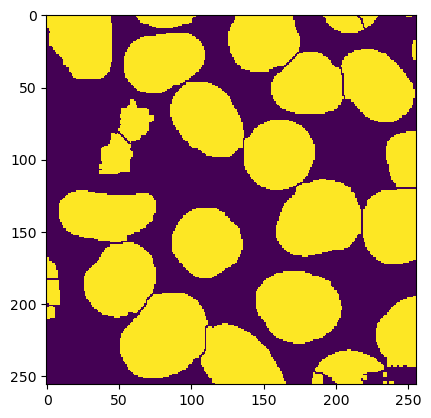

In [8]:
# clean up the binary mask.
ij.IJ.run(mask, "Dilate", "")
ij.IJ.run(mask, "Fill Holes", "")
ij.IJ.run(mask, "Watershed", "")
ij.py.show(mask)

In [9]:
# Save the mask as a selection (a.k.a. ROI).
ij.IJ.run(mask, "Create Selection", "")
roi = mask.getRoi()
ij.IJ.run(mask, "Close", "")

# Split the ROI into cells.
# This works because cells are disconnected due to the watershed.
rois = roi.getRois()
print(len(rois), "cells detected")

32 cells detected


In [10]:
# Calculate statistics.

from collections import defaultdict
from pandas import DataFrame

# Make sure to measure the same slice as segmented!
imp.setPosition(c, z, t)

# Measure each cell, accumulating results into a dictionary.
ij.IJ.run("Set Measurements...", "area mean min centroid median skewness kurtosis redirect=None decimal=3");
results = ij.ResultsTable.getResultsTable()
stats_ij = defaultdict(list)
for cell in rois:
    imp.setRoi(cell)
    ij.IJ.run(imp, "Measure", "")
    for column in results.getHeadings():
        stats_ij[column].append(results.getColumn(column)[0])

In [11]:
# Display the results.
df_ij = DataFrame(stats_ij)
df_ij

,"(A, r, e, a)","(M, e, a, n)","(M, i, n)","(M, a, x)",(X),(Y),"(M, e, d, i, a, n)","(S, k, e, w)","(K, u, r, t)"
0,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
1,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
2,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
3,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
4,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
5,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
6,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
7,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
8,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583
9,8.0,14267.75,12045.0,16929.0,251.0,1.0,14748.0,0.120347,-1.164583


Notice that we avoided using the `RoiManager`, so that the workflow still works in headless mode.

## Segmentation workflow with ImageJ2

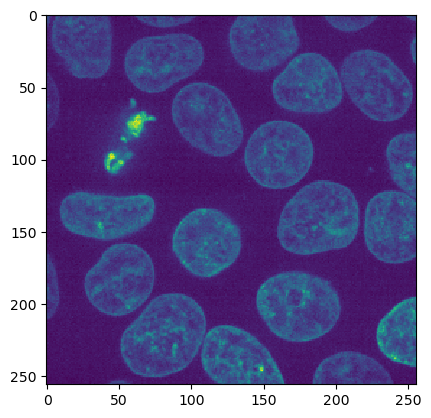

In [12]:
# slice out an image plane.
c, z = 1, 35
cells_slice = xcells[z,c,:,:]
ij.py.show(cells_slice)
jslice = ij.py.to_java(cells_slice)

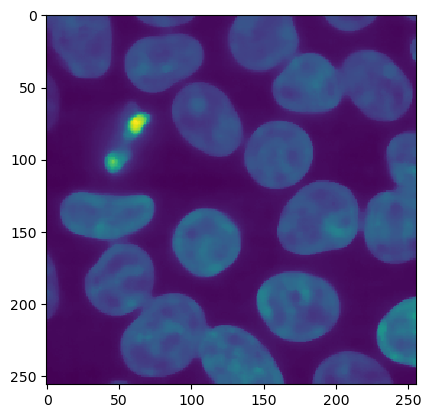

In [13]:
# preprocess with edge-preserving smoothing.
HyperSphereShape = sj.jimport("net.imglib2.algorithm.neighborhood.HyperSphereShape")
smoothed = ij.op().run("create.img", jslice)
ij.op().run("filter.median", ij.py.jargs(smoothed, cells_slice, HyperSphereShape(5)))
ij.py.show(smoothed)

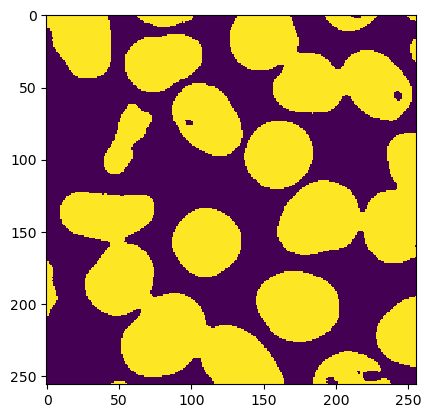

In [14]:
# threshold to binary mask.
mask = ij.op().run("threshold.otsu", smoothed)
ij.py.show(mask)

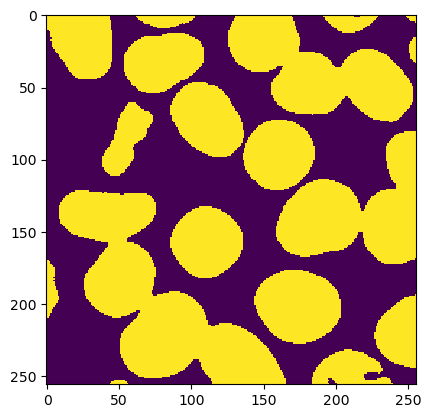

In [15]:
# clean up the binary mask.
mask = ij.op().run("morphology.dilate", mask, HyperSphereShape(1))
mask = ij.op().run("morphology.fillHoles", mask)
ij.py.show(mask)

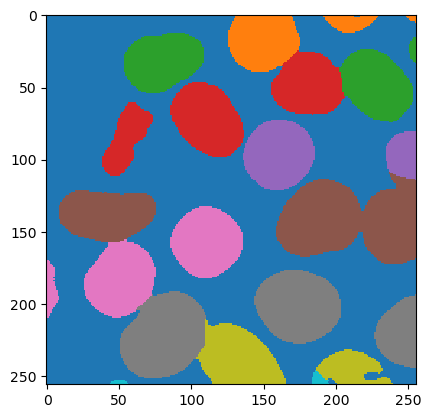

In [16]:
# Watershed: mask to labeling.
use_eight_connectivity = True
draw_watersheds = False
sigma = 10
args = ij.py.jargs(None, mask, use_eight_connectivity, draw_watersheds, sigma, mask)
labeling = ij.op().run("image.watershed", args)
ij.py.show(labeling.getIndexImg(), cmap='tab10')

In [17]:
# calculate statistics.

from collections import defaultdict
from pandas import DataFrame

Regions = sj.jimport("net.imglib2.roi.Regions")
LabelRegions = sj.jimport("net.imglib2.roi.labeling.LabelRegions")

def compute_stats(region, img, stats):
    samples = Regions.sample(region, img)
    stats["area"].append(ij.op().run("stats.size", samples).getRealDouble())
    stats["mean"].append(ij.op().run("stats.mean", samples).getRealDouble())
    min_max = ij.op().run("stats.minMax", samples)
    stats["min"].append(min_max.getA().getRealDouble())
    stats["max"].append(min_max.getB().getRealDouble())
    centroid = ij.op().run("geom.centroid", region)
    stats["centroid"].append(tuple(centroid.getDoublePosition(d) for d in range(centroid.numDimensions())))
    stats["median"].append(ij.op().run("stats.median", samples).getRealDouble())
    stats["skewness"].append(ij.op().run("stats.skewness", samples).getRealDouble())
    stats["kurtosis"].append(ij.op().run("stats.kurtosis", samples).getRealDouble())

regions = LabelRegions(labeling)
stats_ops = defaultdict(list)
for region in regions:
    compute_stats(region, jslice, stats_ops)
df_ops = DataFrame(stats_ops)
df_ops

,area,mean,min,max,centroid,median,skewness,kurtosis
0,1860.0,14358.090860,2845.0,30918.0,"(238.75, 143.9758064516129)",14368.0,0.129771,3.085133
1,1869.0,16544.414660,3177.0,55766.0,"(132.11824505082933, 237.0904226859283)",16028.0,0.846920,5.862000
2,2728.0,13762.175953,3841.0,36656.0,"(81.17192082111437, 222.23717008797655)",13183.0,0.795826,4.241153
3,2445.0,14010.395092,3414.0,32483.0,"(188.73824130879345, 141.48711656441716)",13704.0,0.454090,3.666324
4,2364.0,15095.145516,3367.0,38648.0,"(173.9784263959391, 201.498730964467)",14700.0,0.560561,3.622262
5,1688.0,11611.678318,4220.0,24801.0,"(24.873815165876778, 19.488744075829384)",11476.0,0.413529,3.775973
6,1652.0,12272.721550,4884.0,22525.0,"(149.73365617433413, 18.008474576271187)",12045.0,0.339055,3.104162
7,1077.0,19755.374188,3841.0,49365.0,"(243.6146703806871, 220.35468895078924)",18968.0,0.403299,3.173040
8,1894.0,13802.092397,3936.0,29306.0,"(160.63991552270326, 96.76663146779303)",13704.0,0.090845,3.354490
9,1952.0,12997.042008,3557.0,32720.0,"(51.01485655737705, 183.14241803278688)",12661.0,0.522687,3.443799
